In [486]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import data_visualization as dv
wheel = dv.ColorWheel()

In [487]:
help(stats.norm.cdf)

Help on method cdf in module scipy.stats._distn_infrastructure:

cdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Cumulative distribution function of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    cdf : ndarray
        Cumulative distribution function evaluated at `x`



In [488]:
np.tile(np.arange(0,2000,1),(2,1))

array([[   0,    1,    2, ..., 1997, 1998, 1999],
       [   0,    1,    2, ..., 1997, 1998, 1999]])

In [489]:
class Optimal_Decision_Time_Model():
    def __init__(self, **kwargs):
        # Task Conditions
        self.num_blocks = kwargs.get('num_blocks',6)
        self.agent_means = kwargs.get('agent_means',np.array([1000,1000,1100,1100,1200,1200]))
        self.agent_stds = kwargs.get('agent_stds',np.array([50,150,50,150,50,150]))
        self.nsteps = 1
        self.timesteps = kwargs.get('timesteps',np.tile(np.arange(0,2000,self.nsteps),(self.num_blocks,1)))
        
        
        # Player Parameters
        # Uncertainty
        self.reaction_uncertainty = kwargs.get('reaction_uncertainty')
        self.movement_uncertainty = kwargs.get('movement_uncertainty')
        self.timing_uncertainty = kwargs.get('timing_uncertainty')
        self.reaction_plus_movement_uncertainty = np.sqrt(self.reaction_uncertainty**2 + self.movement_uncertainty**2)
        self.total_uncertainty = np.sqrt(self.reaction_plus_movement_uncertainty**2 + self.timing_uncertainty**2)
        self.total_uncertainty_reaction = self.reaction_plus_movement_uncertainty
        self.total_uncertainty_gamble = self.movement_uncertainty
        self.agent_plus_human_uncertainty = np.sqrt(self.total_uncertainty**2 + self.agent_stds**2)
        # Ability
        self.reaction_time = kwargs.get('reaction_time')
        self.movement_time = kwargs.get('movement_time')
        self.reaction_plus_movement_time = self.reaction_time + self.movement_time
        
        # Reward and cost values
        self.win_reward = kwargs.get('win_reward',1)
        self.incorrect_cost = kwargs.get('incorrect_cost',0)
        self.indecision_cost = kwargs.get('indecision_cost',0)
        # Prob of selecting the correct target
        self.prob_success_gamble = kwargs.get('prob_success_gamble',0.5)
        self.prob_success_reaction = kwargs.get('prob_success_react',1.0)
       
        # Agent probabilities 
        self.prob_agent_has_gone = self.prob_agent_go()
        self.prob_agent_has_not_gone = 1 - self.prob_agent_has_gone
        
        # Prob reacting and gambling
        self.prob_selecting_reaction = self.prob_of_selecting_reaction()
        self.prob_selecting_gamble = 1 - self.prob_selecting_reaction
    
        # Prob of making it on a reaction and gamble 
        self.prob_making_reaction = self.prob_making_when_reacting_or_gambling(react=True)
        self.prob_making_gamble = self.prob_making_when_reacting_or_gambling(gamble=True)
        
        # Probability of receiving a reward (prob_succes multiplied by prob of making it multiplied by probability of being able to select that action)
        self.prob_reward_reaction = self.prob_success_reaction*self.prob_making_reaction*self.prob_selecting_reaction
        self.prob_reward_gamble = self.prob_success_gamble*self.prob_making_gamble*self.prob_selecting_gamble
        
        # Probability of receiving an incorrect cost
        self.prob_incorrect_cost_reaction = (1 - self.prob_success_reaction)*self.prob_making_reaction*self.prob_selecting_reaction
        self.prob_incorrect_cost_gamble = (1 - self.prob_success_gamble)*self.prob_making_gamble*self.prob_selecting_gamble
        
        # Probability of receiving an indecision cost
        self.prob_indecision_cost_reaction = (1 - self.prob_making_reaction)*self.prob_selecting_reaction
        self.prob_indecision_cost_gamble = (1 - self.prob_making_gamble)*self.prob_selecting_gamble
        
        # Expected reward 
        self.exp_reward_reaction = self.prob_reward_reaction*self.win_reward + self.prob_incorrect_cost_reaction*self.incorrect_cost + self.prob_indecision_cost_reaction*self.indecision_cost 
        self.exp_reward_gamble = self.prob_reward_gamble*self.win_reward + self.prob_incorrect_cost_gamble*self.incorrect_cost + self.prob_indecision_cost_gamble*self.indecision_cost 
        self.exp_reward = self.exp_reward_reaction + self.exp_reward_gamble
        
        self.optimal_decision_time = np.argmax(self.exp_reward, axis = 1)*self.nsteps
        self.max_exp_reward = np.max(self.exp_reward,axis=1)
        self.metrics_name_dict = {'exp_reward': 'Expected Reward','exp_reward_gamble': 'Expected Reward Gamble','exp_reward_reaction':'Expected Reward Reaction',
                                  'prob_making_reaction': 'Prob Making Reaction','prob_making_gamble':'Prob Making Gamble','prob_agent_has_gone':'Prob Agent Has Gone',
                                  'prob_selecting_reaction':'Prob of Selecting Reaction'}
        
    def prob_agent_go(self):
        output = np.zeros((self.num_blocks,len(self.timesteps[0,:])))
        for i in range(self.num_blocks):
            output[i,:] = stats.norm.cdf(self.timesteps[i,:],self.agent_means[i],self.agent_stds[i])
        return output
    
    def prob_of_selecting_reaction(self):
        output = np.zeros((self.num_blocks,len(self.timesteps[0,:])))
        for i in range(self.num_blocks):
            combined_uncertainty = np.sqrt(self.total_uncertainty**2 + self.agent_stds[i]**2)
            output[i,:] = stats.norm.cdf(self.timesteps[i,:] - self.agent_means[i],0,combined_uncertainty) # Probability that selecting at the current timestep will be greater than the agent mean (aka react)
        return output
    
    def prob_making_when_reacting_or_gambling(self, react=False,gamble=False):
        output = np.zeros((self.num_blocks,len(self.timesteps[0,:])))
        if react:
            uncertainty = self.reaction_plus_movement_uncertainty
            time_to_target = self.reaction_plus_movement_time
        elif gamble:
            uncertainty = self.movement_uncertainty
            time_to_target = self.movement_time
        for i in range(self.num_blocks):
            output[i,:] = stats.norm.cdf(1500-self.timesteps[i,:],time_to_target,uncertainty)
        return output
    
    def plot_optimals(self,metrics,dpi=125):
        plt.style.use('cashaback_dark')
        for i in range(self.num_blocks):
            fig,ax = plt.subplots(dpi=dpi)
            for metric in metrics:
                ax.plot(self.timesteps[i,:], getattr(self,metric)[i,:], label = self.metrics_name_dict[metric],zorder=0)
                if metric == 'exp_reward':
                    ax.plot((self.optimal_decision_time[i],self.optimal_decision_time[i]),(0,self.max_exp_reward[i]),c='w')
                    ax.scatter(self.optimal_decision_time[i],self.max_exp_reward[i],c='w')
                    ax.text(self.optimal_decision_time[i],self.max_exp_reward[i]+0.03,f'Optimal Decision Time = {self.optimal_decision_time[i]}',horizontalalignment = 'center')
            ax.set_ylim(np.min(self.incorrect_cost,self.indecision_cost)-0.03,np.max(self.win_reward)+0.03)
            ax.set_xlim(0,1500)
            ax.set_xticks(np.arange(0,2000,300))
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Expected Reward')
            ax.legend(fontsize = 8,loc = (0.01,0.1))
            ax.set_title(f'Gain Function for Decision Time\nAgent Mean,SD = {self.agent_means[i]},{self.agent_stds[i]}')#\n B = {B}')
            plt.show()
        
        
        

In [518]:
model.total_uncertainty

114.89125293076057

[1054 1047 1072 1058 1086 1068]
255
[0.79747588 0.77422536 0.66527535 0.68046355 0.56378679 0.60017514]


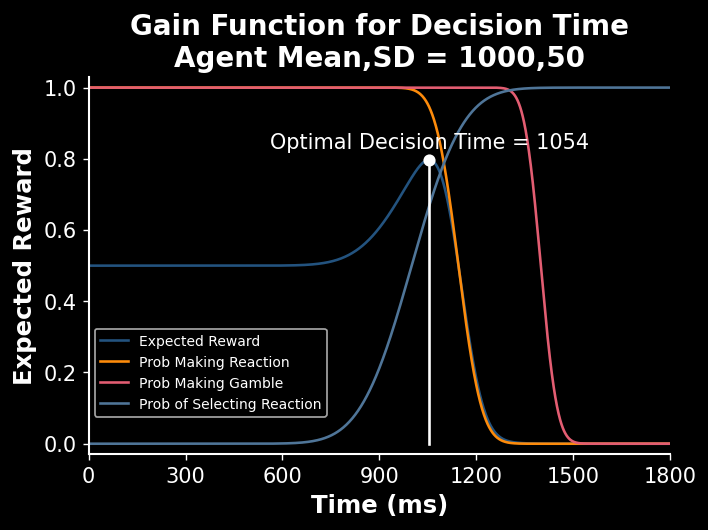

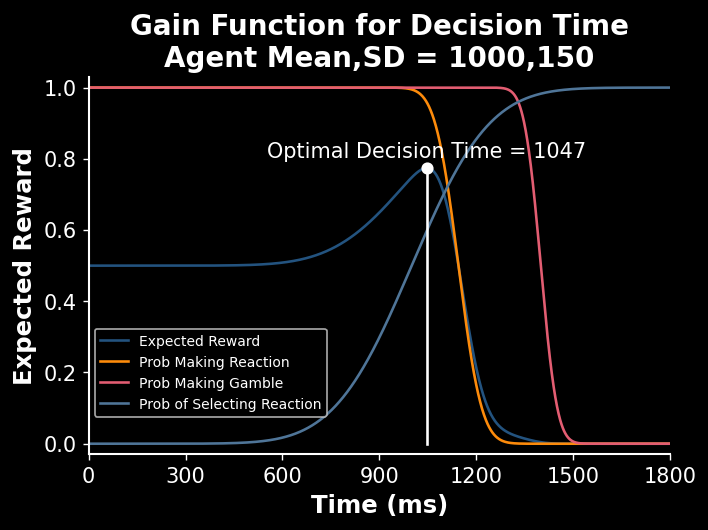

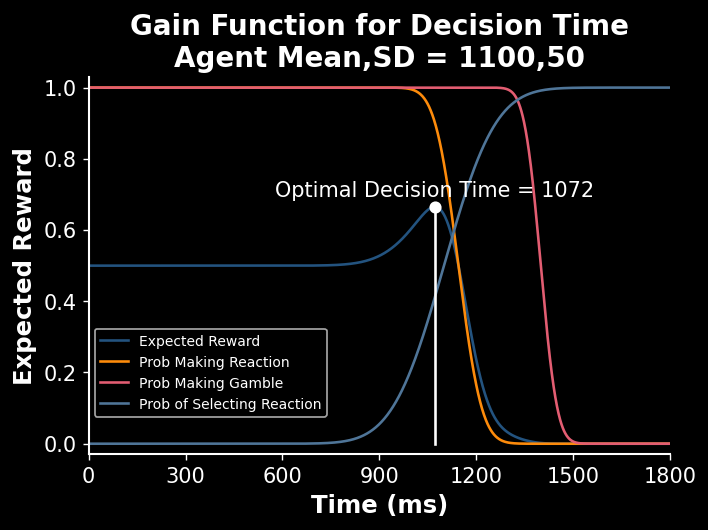

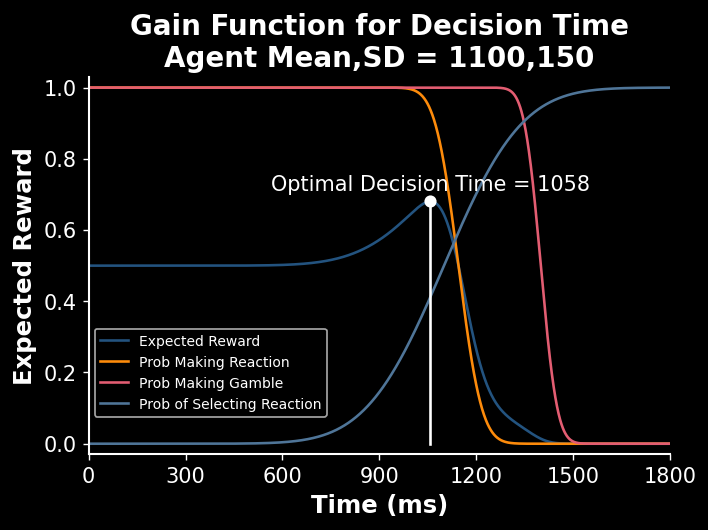

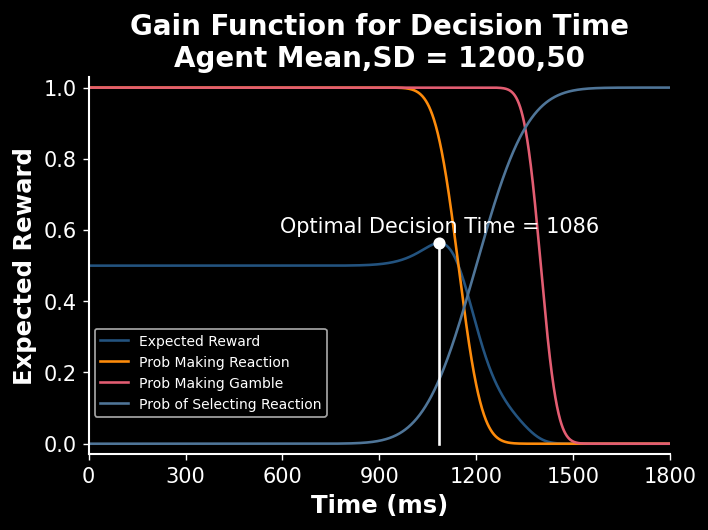

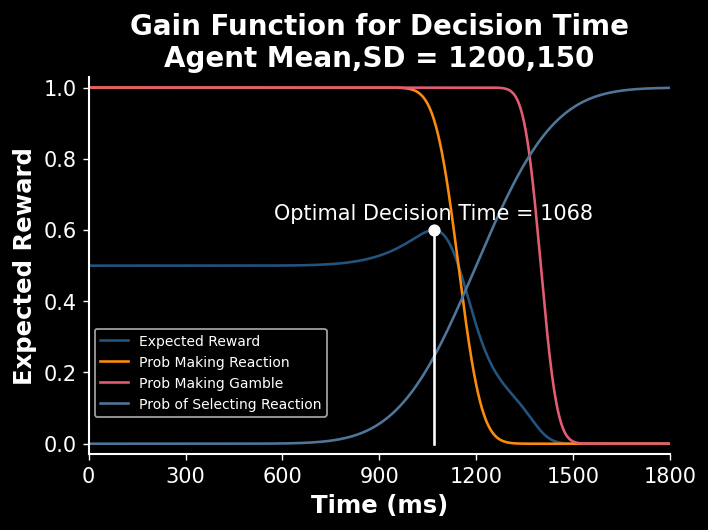

In [517]:
model = Optimal_Decision_Time_Model(reaction_time = 255, movement_time = movement_time, reaction_uncertainty = reaction_uncertainty, movement_uncertainty = movement_uncertainty,
                                    timing_uncertainty = timing_uncertainty, )
print(model.optimal_decision_time)
print(model.reaction_time)
print(model.max_exp_reward)
model.plot_optimals(['exp_reward','prob_making_reaction','prob_making_gamble','prob_selecting_reaction'])

[1054 1047 1072 1058 1086 1068]
255
[0.79747588 0.77422536 0.66527535 0.68046355 0.56378679 0.60017514]


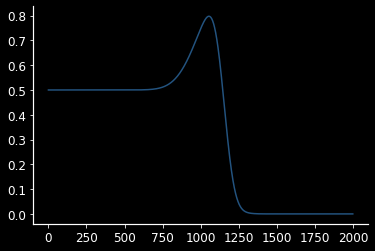

In [492]:
fig, ax = plt.subplots()
ax.plot(model.timesteps[0],model.exp_reward[0])

In [493]:
def plot_optimals(timesteps,exp_reward,exp_reward_gamble,exp_reward_react,prob_reward_gamble,prob_reward_react,
                  prob_agent_go,prob_agent_no_go, prob_reward, movement_time,reaction_movement_time):
    fig,ax = plt.subplots(dpi = 125)
    ax.plot(timesteps, exp_reward, label = 'Exp Reward', c = wheel.green, ls = '--')
    ax.plot(timesteps, exp_reward_gamble, label = 'Exp Reward Gamble')
    ax.plot(timesteps, exp_reward_react, label = 'Exp Reward React')
    ax.plot(timesteps,prob_reward_gamble*prob_agent_no_go,label='Gamble Reward*ProbAgentNoGo')
    ax.plot(timesteps,prob_reward_react*prob_agent_go,label = 'React Reward*ProbAgentGo')
    # ax.plot(timesteps, prob_indecision_gamble)
    ax.set_ylim(-1,1.1)
    ax.set_xlim(0,1500)
    ax.set_xticks(np.arange(0,2000,300))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Expected Reward')
    ax.legend(fontsize = 8,loc = (0.01,0.1))
    ax.set_title(f'Gain Function for Decision Time')#\n B = {B}')
    plt.show()
    optimal_decision_time  = np.argmax(prob_reward) 
    target_reach_time_on_gambles = optimal_decision_time + movement_time 
    target_reach_time_on_reactions = optimal_decision_time + reaction_movement_time
    print(f'Optimal Decision Time: {optimal_decision_time}') # Remember the task decision time is this 
    print(f'Maximum Expected Reward: {np.max(prob_reward)}')
    print(f'Gamble Target Reach Time: {target_reach_time_on_gambles}')
    print(f'Reaction Target Reach Time: {target_reach_time_on_reactions}')

In [494]:
def find_optimal_decision_time_v3(agent_mean, agent_std, reaction_time,movement_time, reaction_uncertainty, movement_uncertainty,timing_uncertainty,plot=False):
    '''
    v3 Is trying to figure out what the best cost function is
    
    - Should it include the probability of the agent going?
    - Maybe it should be the probabiltiy of making it if you react to the agent?
    - 
    
    
    
    '''
    timesteps = np.arange(0,2000,1)
    prob_agent_go = np.zeros(len(timesteps))
    prob_agent_no_go = np.zeros(len(timesteps))
    prob_making_react = np.zeros(len(timesteps))
    prob_making_gamble = np.zeros(len(timesteps))
    prob_agent_making = np.zeros(len(timesteps))

    expected_reward = np.zeros(len(timesteps))
    expected_reward_gamble = np.zeros(len(timesteps))
    expected_reward_react = np.zeros(len(timesteps))
    prob_reward_gamble = np.zeros(len(timesteps))
    prob_reward_react = np.zeros(len(timesteps))
    prob_reward = np.zeros(len(timesteps))
    reaction_movement_time = reaction_time + movement_time


    prob_success_gamble = 0.5 
    prob_success_react = 1.0
    win_reward = 1.0
    loss_cost = 0
    indecision_cost = 0
    
    prob_agent_go = stats.norm.cdf(timesteps,agent_mean,agent_std)
    prob_agent_no_go = 1 - prob_agent_go
    prob_agent_making = stats.norm.cdf(1500-timesteps,agent_mean,agent_std)
    
    # IT'S NOT ABOUT THE PROBABILITY THAT I WILL SUCCEED WITH EACH ACTION... IT'S ABOUT THE PROBABILITY THAT I WILL BE ABLE TO SELECT THE OPTIMAL ACTION
    prob_react = stats.norm.cdf(timesteps,agent_mean,np.sqrt(agent_std**2+timing_uncertainty**2)) # probably of reacting depends on the agent mean, and the uncertainty of my ability to select a specific decision time
    prob_gamble = 1 - prob_react
    
    # Calculate reaction movement uncertainty basedon prob_agent_go
    reaction_movement_uncertainty = np.sqrt((movement_uncertainty)**2 + prob_react*(reaction_uncertainty**2)) # We have some uncertainty about making it  
    total_uncertainty_reaction = np.sqrt(reaction_movement_uncertainty**2 + timing_uncertainty**2)
    total_uncertainty_gamble = np.sqrt(movement_uncertainty**2 + timing_uncertainty**2)  
    
    prob_making_react = stats.norm.cdf(1500-timesteps,reaction_movement_time,total_uncertainty_reaction)
    prob_making_gamble = stats.norm.cdf(1500-timesteps,movement_time,total_uncertainty_gamble)

    # THESE AREN'T Multiplied by Agent Probability     
    prob_reward_gamble = (prob_success_gamble)*prob_making_gamble 
    prob_cost_gamble = (1-prob_success_gamble)*prob_making_gamble # Probability of receiving the Cost for being incorrect
    
    prob_reward_react = (prob_success_react)*prob_making_react 
    prob_cost_react = ((1-prob_success_react))*prob_making_react # Probability of receiving the Cost for being incorrect
    
    prob_indecision_gamble = (1 - prob_making_gamble)
    prob_indecision_react = (1 - prob_making_react)    
    
    # Don't need AND subtraction because the prob_agent_go and prob_agent_no_go takes care of it
    # These are multiplied by agent probability, because that's the probability that I SELECT GAMBLE and SELECT REACTION
    prob_reward = prob_reward_gamble*prob_gamble + prob_reward_react*prob_react #- (prob_reward_gamble*prob_reward_react) # NEED TO SUBTRACT THE AND PROBABILITY?... this makes sense... If I go at that time, I at least have 0.5 PLUS the probability that the agent has gone will boost it up
    prob_cost = prob_cost_gamble*prob_gamble + prob_cost_react*prob_react # - (prob_cost_react*prob_cost_gamble)
    prob_indecision = prob_indecision_gamble*prob_gamble + prob_indecision_react*prob_react #- (prob_indecision_gamble*prob_indecision_react) # Probability of indecision depends on if someone gambles
    
    #prob_indecision = prob_indecision_gamble*(1-B) + prob_indecision_react*B - prob_indecision_gamble*(1-B)*B*prob_indecision_react # Probability of indecision depends on if someone gambles 
    
    exp_reward_gamble = prob_reward_gamble*win_reward + prob_cost_gamble*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward_react = prob_reward_react*win_reward + prob_cost_react*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward = prob_reward*win_reward + prob_cost*loss_cost + (prob_indecision)*indecision_cost
    
    plot_optimals(timesteps,exp_reward,exp_reward_gamble,exp_reward_react,prob_reward_gamble,prob_reward_react,
                  prob_agent_go,prob_agent_no_go,prob_reward, movement_time,reaction_movement_time)
        
    return np.argmax(exp_reward),np.max(exp_reward),total_uncertainty_reaction,total_uncertainty_gamble

(0.0, 0.1)

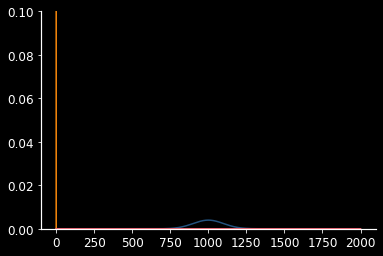

In [495]:
mu = 1000
std = 100
clip_a,clib_b = 1000,1033
a,b = (clip_a - mu)/std, (clib_b - mu)/std
x = np.arange(0,2000,1)
trunc_pdf = stats.truncnorm.pdf(x,a,b)
pdf = stats.norm.pdf(x,mu,std)
fig, ax = plt.subplots()

ax.plot(x,pdf)
ax.plot(x,trunc_pdf)
rv = stats.truncnorm.pdf(x,10,20,loc=mu,scale=std)
ax.plot(x,rv)
ax.set_ylim(0,0.1)

In [496]:
agent_mean = 1000
agent_std = 50
reaction_time = 325
movement_time = 100
movement_uncertainty = 40
reaction_uncertainty = 40
timing_uncertainty = 100


timesteps = np.arange(0,2000,1)
prob_agent_go = np.zeros(len(timesteps))
prob_agent_no_go = np.zeros(len(timesteps))
prob_making_react = np.zeros(len(timesteps))
prob_making_gamble = np.zeros(len(timesteps))
prob_agent_making = np.zeros(len(timesteps))

expected_reward = np.zeros(len(timesteps))
expected_reward_gamble = np.zeros(len(timesteps))
expected_reward_react = np.zeros(len(timesteps))
prob_reward_gamble = np.zeros(len(timesteps))
prob_reward_react = np.zeros(len(timesteps))
prob_reward = np.zeros(len(timesteps))
reaction_movement_time = reaction_time + movement_time


prob_success_gamble = 0.5 # IT'S NOT ABOUT THE PROBABILITY THAT I WILL SUCCEED WITH EACH ACTION... IT'S ABOUT THE PROBABILITY THAT I WILL BE ABLE TO SELECT THE OPTIMAL ACTION
prob_success_react = 1.0
win_reward = 1.0
loss_cost = 0
indecision_cost = 0

prob_agent_go = stats.norm.cdf(timesteps,agent_mean,agent_std)
prob_agent_no_go = 1 - prob_agent_go
prob_agent_making = stats.norm.cdf(1500-timesteps,agent_mean,agent_std)


# Calculate reaction movement uncertainty basedon prob_agent_go
reaction_movement_uncertainty = np.sqrt((movement_uncertainty)**2 + prob_agent_go*(reaction_uncertainty**2)) # We have some uncertainty about making it  
total_uncertainty_reaction = np.sqrt(reaction_movement_uncertainty**2) #+ timing_uncertainty**2)
total_uncertainty_gamble = np.sqrt(movement_uncertainty**2 + timing_uncertainty**2)  

prob_making_react = stats.norm.cdf(1500-timesteps,reaction_movement_time,total_uncertainty_reaction)
prob_making_gamble = stats.norm.cdf(1500-timesteps,movement_time,total_uncertainty_gamble)

# THESE AREN'T Multiplied by Agent Probability     
prob_reward_gamble = (prob_success_gamble)*prob_making_gamble 
prob_cost_gamble = (1-prob_success_gamble)*prob_making_gamble # Probability of receiving the Cost for being incorrect

prob_reward_react = (prob_success_react)*prob_making_react 
prob_cost_react = ((1-prob_success_react))*prob_making_react # Probability of receiving the Cost for being incorrect

prob_indecision_gamble = (1 - prob_making_gamble)
prob_indecision_react = (1 - prob_making_react)    

# Don't need AND subtraction because the prob_agent_go and prob_agent_no_go takes care of it
# These are multiplied by agent probability, because that's the probability that I SELECT GAMBLE and SELECT REACTION
prob_reward = prob_reward_gamble*prob_agent_no_go + prob_reward_react*prob_agent_go #- (prob_reward_gamble*prob_reward_react) # NEED TO SUBTRACT THE AND PROBABILITY?... this makes sense... If I go at that time, I at least have 0.5 PLUS the probability that the agent has gone will boost it up
prob_cost = prob_cost_gamble*prob_agent_no_go + prob_cost_react*prob_agent_go # - (prob_cost_react*prob_cost_gamble)
prob_indecision = prob_indecision_gamble*prob_agent_no_go + prob_indecision_react*prob_agent_go #- (prob_indecision_gamble*prob_indecision_react) # Probability of indecision depends on if someone gambles

#prob_indecision = prob_indecision_gamble*(1-B) + prob_indecision_react*B - prob_indecision_gamble*(1-B)*B*prob_indecision_react # Probability of indecision depends on if someone gambles 

exp_reward_gamble = prob_reward_gamble*win_reward + prob_cost_gamble*loss_cost + prob_indecision_gamble*indecision_cost
exp_reward_react = prob_reward_react*win_reward + prob_cost_react*loss_cost + prob_indecision_gamble*indecision_cost
exp_reward = prob_reward*win_reward + prob_cost*loss_cost + (prob_indecision)*indecision_cost

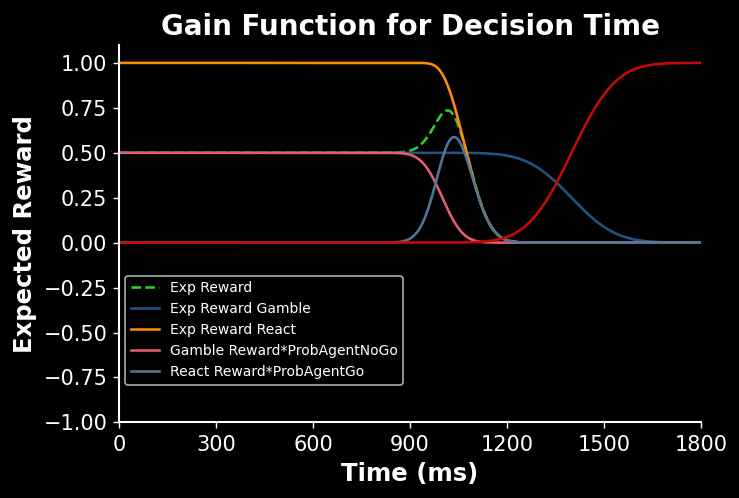

Optimal Decision Time: 1016
Maximum Expected Reward: 0.7353749342693313
Gamble Target Reach Time: 1116
Reaction Target Reach Time: 1441


In [497]:
fig,ax = plt.subplots(dpi = 125)
ax.plot(timesteps, exp_reward, label = 'Exp Reward', c = wheel.green, ls = '--')
ax.plot(timesteps, exp_reward_gamble, label = 'Exp Reward Gamble')
ax.plot(timesteps, exp_reward_react, label = 'Exp Reward React')
ax.plot(timesteps,prob_reward_gamble*prob_agent_no_go,label='Gamble Reward*ProbAgentNoGo')
ax.plot(timesteps,prob_reward_react*prob_agent_go,label = 'React Reward*ProbAgentGo')
ax.plot(timesteps, prob_indecision_gamble)
ax.set_ylim(-1,1.1)
ax.set_xlim(0,1500)
ax.set_xticks(np.arange(0,2000,300))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Expected Reward')
ax.legend(fontsize = 8,loc = (0.01,0.1))
ax.set_title(f'Gain Function for Decision Time')#\n B = {B}')
plt.show()
optimal_decision_time  = np.argmax(prob_reward) 
target_reach_time_on_gambles = optimal_decision_time + movement_time 
target_reach_time_on_reactions = optimal_decision_time + reaction_movement_time
print(f'Optimal Decision Time: {optimal_decision_time}') # Remember the task decision time is this 
print(f'Maximum Expected Reward: {np.max(prob_reward)}')
print(f'Gamble Target Reach Time: {target_reach_time_on_gambles}')
print(f'Reaction Target Reach Time: {target_reach_time_on_reactions}')

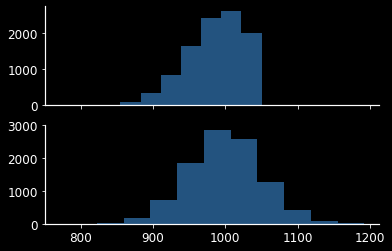

In [498]:
lower, upper = 0, 1050
mu, sigma = 1000, 50
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, 
                    loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)

fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000))#, normed=True)
ax[1].hist(N.rvs(10000))#, normed=True)
plt.show()

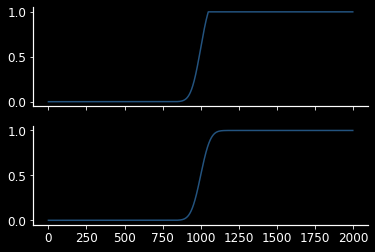

In [499]:
fig, ax = plt.subplots(2, sharex=True)
x = np.arange(0,2000,1)
ax[0].plot(x,X.cdf(x))#, normed=True)
ax[1].plot(x,N.cdf(x))#, normed=True)
plt.show()

In [500]:
np.argmax(prob_reward_react*prob_agent_go)

1036

In [501]:
stats.norm.cdf(1500,1016+reaction_time+movement_time,50)


0.8809998925447993

In [502]:
stats.norm.cdf(1016,agent_mean,agent_std)

0.6255158347233201

In [503]:
stats.norm.cdf(1016,agent_mean,agent_std)*stats.norm.cdf(1500,1016+reaction_time+movement_time,50)

0.5510793831763154

In [504]:
# def max_prob_of_winning_on_react(agent_mean,agent_std,decision_time_means,decision_time_stds):
    

In [505]:
decision_times = np.arange(0,2000,1)
agent_mean,agent_std = 1000,50
uncertainty_both = np.sqrt(agent_std**2 + 100**2)
prob_using_agent = stats.norm.cdf(decision_times,agent_mean,uncertainty_both) # Prob that decision times are greater than the agent mean
prob_making_react = stats.norm.cdf(1500,decision_times+reaction_time+movement_time,45) # Prob that decision time plus reaction time plus movement time is before 1500
opt_decision_time = np.argmax(prob_using_agent*prob_making_react)
print(opt_decision_time)

1027


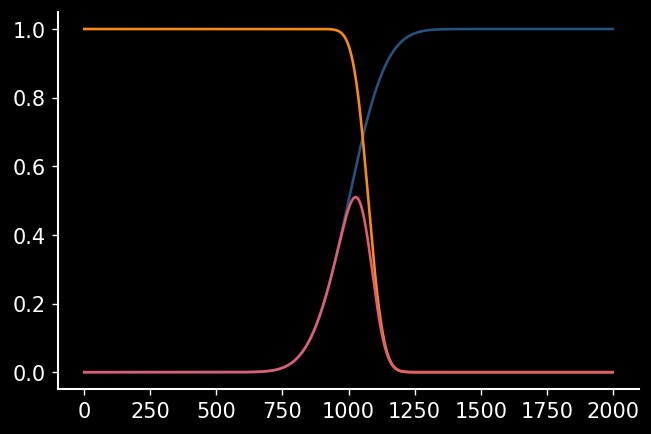

In [506]:
fig,ax = plt.subplots(dpi=125)
ax.plot(decision_times,prob_using_agent)
ax.plot(decision_times,prob_making_react)
ax.plot(decision_times,prob_using_agent*prob_making_react)

In [507]:
def truncated_mean(a,b,mean,std,num_runs):
    all_rvs = np.zeros(num_runs)*np.nan
    c=-1
    while c < num_runs-1:
        c+=1
        rv =stats.norm.rvs(loc=mean,scale=std)
        if a<rv<b:
            all_rvs[c] = rv
        else:
            c-=1
    return np.nanmean(all_rvs),all_rvs

In [508]:
true_react_decision_time,all_rvs = truncated_mean(0,opt_decision_time,agent_mean,agent_std,1000)
print(true_react_decision_time)

prob_making_react_optimal = stats.norm.cdf(1500,true_react_decision_time+reaction_time+movement_time,45)
prob_making_gamble_optimal = stats.norm.cdf(1500,opt_decision_time+movement_time,100)

prob_using_agent = stats.norm.cdf(opt_decision_time,agent_mean,uncertainty_both)

print(prob_making_react_optimal,prob_making_gamble_optimal)
print(prob_using_agent)

976.4026779005759
0.9857759707670738 0.9999042601147311
0.5954143867246472


In [509]:
prob_making_react_optimal*prob_using_agent + 0.5*prob_making_gamble_optimal*(1-prob_using_agent)

0.7892186342297492

In [510]:
prob_making_react_optimal*prob_using_agent

0.586945195082171

In [511]:
(1-prob_making_react_optimal)*prob_using_agent

0.00846919164247621